### 1. Testing the development environment

In [1]:
import cv2
import numpy as np

# Checking the OpenCV version
print("OpenCV version", cv2.__version__)

# Checking the Numpy version
print("Numpy version", np.__version__)


OpenCV version 3.1.0
Numpy version 1.13.1


### 2. Markov Random Field

Markov Random Fields (MRFs), is a formulation which is widely used in generative image modeling.

> Link: An MRF Deep Learning to model to to express the complex interactions among pixels.
http://dahua.me/publications/dhl16_deepmrf.pdf

Lets see an example of Markov Random Field to denoise an image

0.608932495117
None


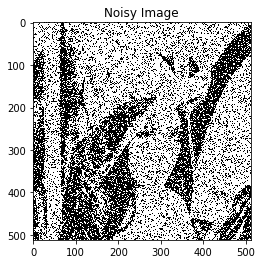

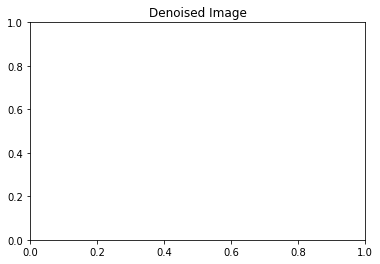

In [25]:
# Image denoising using MRF model
from PIL import Image
import numpy
from pylab import *

def MRF_denoise(noisy):
    # Start MRF
    (M,N)=noisy.shape
    y_old=noisy
    y=zeros((M,N))

    while(SNR(y_old,y)>0.01):
        print(SNR(y_old,y))
        for i in range(M):
            for j in range(N):
                index=neighbor(i,j,M,N)

                a=cost(1,noisy[i,j],y_old,index)
                b=cost(0,noisy[i,j],y_old,index)

                if a>b:
                    y[i,j]=1
                else:
                    y[i,j]=0
        y_old=yield
    print(SNR(y_old,y))
    return y

def SNR(A,B):
    if A.shape==B.shape:
        return numpy.sum(numpy.abs(A-B))/A.size
    else:
        raise Exception("Two matrices must have the same size!")

def delta(a,b):
    if (a==b):
        return 1
    else:
        return 0

def neighbor(i,j,M,N):
	#find correct neighbors
	if (i==0 and j==0):
		neighbor=[(0,1), (1,0)]
	elif i==0 and j==N-1:
		neighbor=[(0,N-2), (1,N-1)]
	elif i==M-1 and j==0:
		neighbor=[(M-1,1), (M-2,0)]
	elif i==M-1 and j==N-1:
		neighbor=[(M-1,N-2), (M-2,N-1)]
	elif i==0:
		neighbor=[(0,j-1), (0,j+1), (1,j)]
	elif i==M-1:
		neighbor=[(M-1,j-1), (M-1,j+1), (M-2,j)]
	elif j==0:
		neighbor=[(i-1,0), (i+1,0), (i,1)]
	elif j==N-1:
		neighbor=[(i-1,N-1), (i+1,N-1), (i,N-2)]
	else:
		neighbor=[(i-1,j), (i+1,j), (i,j-1), (i,j+1),\
				  (i-1,j-1), (i-1,j+1), (i+1,j-1), (i+1,j+1)]
	return neighbor

def cost(y,x,y_old,index):
    alpha=1
    beta=10
    return alpha*delta(y,x)+\
        beta*sum(delta(y,y_old[i]) for i in index)

# Read in image
im=Image.open('../images/lena512.bmp')
im=numpy.array(im)
im=where (im>100,1,0) #convert to binary image
(M,N)=im.shape

# Add noise
noisy=im.copy()
noise=numpy.random.rand(M,N)
ind=where(noise<0.2)
noisy[ind]=1-noisy[ind]

gray()
title('Noisy Image')
imshow(noisy)

out=MRF_denoise(noisy)

figure()
gray()
title('Denoised Image')
print(next(out))
#print()
#imshow(next(out))
show()

### 3. Predicting Depth in Images

We will see a CNN model trained for depth prediction from a single RGB image, as described in the paper "Deeper Depth Prediction with Fully Convolutional Residual Networks".

Paper Link: https://arxiv.org/pdf/1606.00373.pdf


#### Information of CNN

1. Theory
http://colah.github.io/posts/2014-07-Understanding-Convolutions/
http://cs231n.github.io/

2. CNN - Tensorflow
https://www.tensorflow.org/tutorials/deep_cnn

####  Creating the API

In [27]:
import numpy as np
import tensorflow as tf

# ----------------------------------------------------------------------------------
# Commonly used layers and operations based on ethereon's implementation 
# https://github.com/ethereon/caffe-tensorflow
# Slight modifications may apply. FCRN-specific operations have also been appended. 
# ----------------------------------------------------------------------------------
# Thanks to *Helisa Dhamo* for the model conversion and integration into TensorFlow.
# ----------------------------------------------------------------------------------

DEFAULT_PADDING = 'SAME'


def get_incoming_shape(incoming):
    """ Returns the incoming data shape """
    if isinstance(incoming, tf.Tensor):
        return incoming.get_shape().as_list()
    elif type(incoming) in [np.array, list, tuple]:
        return np.shape(incoming)
    else:
        raise Exception("Invalid incoming layer.")


def interleave(tensors, axis):
    old_shape = get_incoming_shape(tensors[0])[1:]
    new_shape = [-1] + old_shape
    new_shape[axis] *= len(tensors)
    return tf.reshape(tf.stack(tensors, axis + 1), new_shape)

def layer(op):
    '''Decorator for composable network layers.'''

    def layer_decorated(self, *args, **kwargs):
        # Automatically set a name if not provided.
        name = kwargs.setdefault('name', self.get_unique_name(op.__name__))

        # Figure out the layer inputs.
        if len(self.terminals) == 0:
            raise RuntimeError('No input variables found for layer %s.' % name)
        elif len(self.terminals) == 1:
            layer_input = self.terminals[0]
        else:
            layer_input = list(self.terminals)
        # Perform the operation and get the output.
        layer_output = op(self, layer_input, *args, **kwargs)
        # Add to layer LUT.
        self.layers[name] = layer_output
        # This output is now the input for the next layer.
        self.feed(layer_output)
        # Return self for chained calls.
        return self

    return layer_decorated


class Network(object):

    def __init__(self, inputs, batch, keep_prob, is_training, trainable = True):
        # The input nodes for this network
        self.inputs = inputs
        # The current list of terminal nodes
        self.terminals = []
        # Mapping from layer names to layers
        self.layers = dict(inputs)
        # If true, the resulting variables are set as trainable
        self.trainable = trainable
        self.batch_size = batch
        self.keep_prob = keep_prob
        self.is_training = is_training
        self.setup()


    def setup(self):
        '''Construct the network. '''
        raise NotImplementedError('Must be implemented by the subclass.')

    def load(self, data_path, session, ignore_missing=False):
        '''Load network weights.
        data_path: The path to the numpy-serialized network weights
        session: The current TensorFlow session
        ignore_missing: If true, serialized weights for missing layers are ignored.
        '''
        data_dict = np.load(data_path, encoding='latin1').item()
        for op_name in data_dict: 
            with tf.variable_scope(op_name, reuse=True):
                for param_name, data in iter(data_dict[op_name].items()):      
                    try:
                        var = tf.get_variable(param_name)
                        session.run(var.assign(data))

                    except ValueError:
                        if not ignore_missing:
                            raise

    def feed(self, *args):
        '''Set the input(s) for the next operation by replacing the terminal nodes.
        The arguments can be either layer names or the actual layers.
        '''
        assert len(args) != 0
        self.terminals = []
        for fed_layer in args:
            if isinstance(fed_layer, str):
                try:
                    fed_layer = self.layers[fed_layer]
                except KeyError:
                    raise KeyError('Unknown layer name fed: %s' % fed_layer)
            self.terminals.append(fed_layer)
        return self

    def get_output(self):
        '''Returns the current network output.'''
        return self.terminals[-1]

    def get_layer_output(self, name):
        return self.layers[name]

    def get_unique_name(self, prefix):
        '''Returns an index-suffixed unique name for the given prefix.
        This is used for auto-generating layer names based on the type-prefix.
        '''
        ident = sum(t.startswith(prefix) for t, _ in self.layers.items()) + 1
        return '%s_%d' % (prefix, ident)

    def make_var(self, name, shape):
        '''Creates a new TensorFlow variable.'''
        return tf.get_variable(name, shape, dtype = 'float32', trainable=self.trainable)

    def validate_padding(self, padding):
        '''Verifies that the padding is one of the supported ones.'''
        assert padding in ('SAME', 'VALID')

    @layer
    def conv(self,
             input_data,
             k_h,
             k_w,
             c_o,
             s_h,
             s_w,
             name,
             relu=True,
             padding=DEFAULT_PADDING,
             group=1,
             biased=True):

        # Verify that the padding is acceptable
        self.validate_padding(padding)
        # Get the number of channels in the input
        c_i = input_data.get_shape()[-1]

        if (padding == 'SAME'):
            input_data = tf.pad(input_data, [[0, 0], [(k_h - 1)//2, (k_h - 1)//2], [(k_w - 1)//2, (k_w - 1)//2], [0, 0]], "CONSTANT")
        
        # Verify that the grouping parameter is valid
        assert c_i % group == 0
        assert c_o % group == 0
        # Convolution for a given input and kernel
        convolve = lambda i, k: tf.nn.conv2d(i, k, [1, s_h, s_w, 1], padding='VALID')
        
        with tf.variable_scope(name) as scope:
            kernel = self.make_var('weights', shape=[k_h, k_w, c_i // group, c_o])

            if group == 1:
                # This is the common-case. Convolve the input without any further complications.
                output = convolve(input_data, kernel)
            else:
                # Split the input into groups and then convolve each of them independently

                input_groups = tf.split(3, group, input_data)
                kernel_groups = tf.split(3, group, kernel)
                output_groups = [convolve(i, k) for i, k in zip(input_groups, kernel_groups)]
                # Concatenate the groups
                output = tf.concat(3, output_groups)

            # Add the biases
            if biased:
                biases = self.make_var('biases', [c_o])
                output = tf.nn.bias_add(output, biases)
            if relu:
                # ReLU non-linearity
                output = tf.nn.relu(output, name=scope.name)

            return output

    @layer
    def relu(self, input_data, name):
        return tf.nn.relu(input_data, name=name)

    @layer
    def max_pool(self, input_data, k_h, k_w, s_h, s_w, name, padding=DEFAULT_PADDING):
        self.validate_padding(padding)
        return tf.nn.max_pool(input_data,
                              ksize=[1, k_h, k_w, 1],
                              strides=[1, s_h, s_w, 1],
                              padding=padding,
                              name=name)

    @layer
    def avg_pool(self, input_data, k_h, k_w, s_h, s_w, name, padding=DEFAULT_PADDING):
        self.validate_padding(padding)
        return tf.nn.avg_pool(input_data,
                              ksize=[1, k_h, k_w, 1],
                              strides=[1, s_h, s_w, 1],
                              padding=padding,
                              name=name)

    @layer
    def lrn(self, input_data, radius, alpha, beta, name, bias=1.0):
        return tf.nn.local_response_normalization(input_data,
                                                  depth_radius=radius,
                                                  alpha=alpha,
                                                  beta=beta,
                                                  bias=bias,
                                                  name=name)

    @layer
    def concat(self, inputs, axis, name):
        return tf.concat(concat_dim=axis, values=inputs, name=name)

    @layer
    def add(self, inputs, name):
        return tf.add_n(inputs, name=name)

    @layer
    def fc(self, input_data, num_out, name, relu=True):
        with tf.variable_scope(name) as scope:
            input_shape = input_data.get_shape()
            if input_shape.ndims == 4:
                # The input is spatial. Vectorize it first.
                dim = 1
                for d in input_shape[1:].as_list():
                    dim *= d
                feed_in = tf.reshape(input_data, [-1, dim])
            else:
                feed_in, dim = (input_data, input_shape[-1].value)
            weights = self.make_var('weights', shape=[dim, num_out])
            biases = self.make_var('biases', [num_out])
            op = tf.nn.relu_layer if relu else tf.nn.xw_plus_b
            fc = op(feed_in, weights, biases, name=scope.name)
            return fc

    @layer
    def softmax(self, input_data, name):
        input_shape = map(lambda v: v.value, input_data.get_shape())
        if len(input_shape) > 2:
            # For certain models (like NiN), the singleton spatial dimensions
            # need to be explicitly squeezed, since they're not broadcast-able
            # in TensorFlow's NHWC ordering (unlike Caffe's NCHW).
            if input_shape[1] == 1 and input_shape[2] == 1:
                input_data = tf.squeeze(input_data, squeeze_dims=[1, 2])
            else:
                raise ValueError('Rank 2 tensor input expected for softmax!')
        return tf.nn.softmax(input_data, name)

    @layer
    def batch_normalization(self, input_data, name, scale_offset=True, relu=False):

        with tf.variable_scope(name) as scope:
            shape = [input_data.get_shape()[-1]]
            pop_mean = tf.get_variable("mean", shape, initializer = tf.constant_initializer(0.0), trainable=False)
            pop_var = tf.get_variable("variance", shape, initializer = tf.constant_initializer(1.0), trainable=False)
            epsilon = 1e-4
            decay = 0.999
            if scale_offset:
                scale = tf.get_variable("scale", shape, initializer = tf.constant_initializer(1.0))
                offset = tf.get_variable("offset", shape, initializer = tf.constant_initializer(0.0))
            else:
                scale, offset = (None, None)
            if self.is_training:
                batch_mean, batch_var = tf.nn.moments(input_data, [0, 1, 2])

                train_mean = tf.assign(pop_mean,
                               pop_mean * decay + batch_mean * (1 - decay))
                train_var = tf.assign(pop_var,
                              pop_var * decay + batch_var * (1 - decay))
                with tf.control_dependencies([train_mean, train_var]):
                    output = tf.nn.batch_normalization(input_data,
                    batch_mean, batch_var, offset, scale, epsilon, name = name)
            else:
                output = tf.nn.batch_normalization(input_data,
                pop_mean, pop_var, offset, scale, epsilon, name = name)

            if relu:
                output = tf.nn.relu(output)

            return output

    @layer
    def dropout(self, input_data, keep_prob, name):
        return tf.nn.dropout(input_data, keep_prob, name=name)
    

    def unpool_as_conv(self, size, input_data, id, stride = 1, ReLU = False, BN = True):

		# Model upconvolutions (unpooling + convolution) as interleaving feature
		# maps of four convolutions (A,B,C,D). Building block for up-projections. 


        # Convolution A (3x3)
        # --------------------------------------------------
        layerName = "layer%s_ConvA" % (id)
        self.feed(input_data)
        self.conv( 3, 3, size[3], stride, stride, name = layerName, padding = 'SAME', relu = False)
        outputA = self.get_output()

        # Convolution B (2x3)
        # --------------------------------------------------
        layerName = "layer%s_ConvB" % (id)
        padded_input_B = tf.pad(input_data, [[0, 0], [1, 0], [1, 1], [0, 0]], "CONSTANT")
        self.feed(padded_input_B)
        self.conv(2, 3, size[3], stride, stride, name = layerName, padding = 'VALID', relu = False)
        outputB = self.get_output()

        # Convolution C (3x2)
        # --------------------------------------------------
        layerName = "layer%s_ConvC" % (id)
        padded_input_C = tf.pad(input_data, [[0, 0], [1, 1], [1, 0], [0, 0]], "CONSTANT")
        self.feed(padded_input_C)
        self.conv(3, 2, size[3], stride, stride, name = layerName, padding = 'VALID', relu = False)
        outputC = self.get_output()

        # Convolution D (2x2)
        # --------------------------------------------------
        layerName = "layer%s_ConvD" % (id)
        padded_input_D = tf.pad(input_data, [[0, 0], [1, 0], [1, 0], [0, 0]], "CONSTANT")
        self.feed(padded_input_D)
        self.conv(2, 2, size[3], stride, stride, name = layerName, padding = 'VALID', relu = False)
        outputD = self.get_output()

        # Interleaving elements of the four feature maps
        # --------------------------------------------------
        left = interleave([outputA, outputB], axis=1)  # columns
        right = interleave([outputC, outputD], axis=1)  # columns
        Y = interleave([left, right], axis=2) # rows
        
        if BN:
            layerName = "layer%s_BN" % (id)
            self.feed(Y)
            self.batch_normalization(name = layerName, scale_offset = True, relu = False)
            Y = self.get_output()

        if ReLU:
            Y = tf.nn.relu(Y, name = layerName)
        
        return Y


    def up_project(self, size, id, stride = 1, BN = True):
        
        # Create residual upsampling layer (UpProjection)

        input_data = self.get_output()

        # Branch 1
        id_br1 = "%s_br1" % (id)

        # Interleaving Convs of 1st branch
        out = self.unpool_as_conv(size, input_data, id_br1, stride, ReLU=True, BN=True)

        # Convolution following the upProjection on the 1st branch
        layerName = "layer%s_Conv" % (id)
        self.feed(out)
        self.conv(size[0], size[1], size[3], stride, stride, name = layerName, relu = False)

        if BN:
            layerName = "layer%s_BN" % (id)
            self.batch_normalization(name = layerName, scale_offset=True, relu = False)

        # Output of 1st branch
        branch1_output = self.get_output()

            
        # Branch 2
        id_br2 = "%s_br2" % (id)
        # Interleaving convolutions and output of 2nd branch
        branch2_output = self.unpool_as_conv(size, input_data, id_br2, stride, ReLU=False)

        
        # sum branches
        layerName = "layer%s_Sum" % (id)
        output = tf.add_n([branch1_output, branch2_output], name = layerName)
        # ReLU
        layerName = "layer%s_ReLU" % (id)
        output = tf.nn.relu(output, name=layerName)

        self.feed(output)
        return self

#### Model

In [29]:
class ResNet50UpProj(Network):
    def setup(self):
        (self.feed('data')
             .conv(7, 7, 64, 2, 2, relu=False, name='conv1')
             .batch_normalization(relu=True, name='bn_conv1')
             .max_pool(3, 3, 2, 2, name='pool1')
             .conv(1, 1, 256, 1, 1, biased=False, relu=False, name='res2a_branch1')
             .batch_normalization(name='bn2a_branch1'))

        (self.feed('pool1')
             .conv(1, 1, 64, 1, 1, biased=False, relu=False, name='res2a_branch2a')
             .batch_normalization(relu=True, name='bn2a_branch2a')
             .conv(3, 3, 64, 1, 1, biased=False, relu=False, name='res2a_branch2b')
             .batch_normalization(relu=True, name='bn2a_branch2b')
             .conv(1, 1, 256, 1, 1, biased=False, relu=False, name='res2a_branch2c')
             .batch_normalization(name='bn2a_branch2c'))

        (self.feed('bn2a_branch1',
                   'bn2a_branch2c')
             .add(name='res2a')
             .relu(name='res2a_relu')
             .conv(1, 1, 64, 1, 1, biased=False, relu=False, name='res2b_branch2a')
             .batch_normalization(relu=True, name='bn2b_branch2a')
             .conv(3, 3, 64, 1, 1, biased=False, relu=False, name='res2b_branch2b')
             .batch_normalization(relu=True, name='bn2b_branch2b')
             .conv(1, 1, 256, 1, 1, biased=False, relu=False, name='res2b_branch2c')
             .batch_normalization(name='bn2b_branch2c'))

        (self.feed('res2a_relu',
                   'bn2b_branch2c')
             .add(name='res2b')
             .relu(name='res2b_relu')
             .conv(1, 1, 64, 1, 1, biased=False, relu=False, name='res2c_branch2a')
             .batch_normalization(relu=True, name='bn2c_branch2a')
             .conv(3, 3, 64, 1, 1, biased=False, relu=False, name='res2c_branch2b')
             .batch_normalization(relu=True, name='bn2c_branch2b')
             .conv(1, 1, 256, 1, 1, biased=False, relu=False, name='res2c_branch2c')
             .batch_normalization(name='bn2c_branch2c'))

        (self.feed('res2b_relu',
                   'bn2c_branch2c')
             .add(name='res2c')
             .relu(name='res2c_relu')
             .conv(1, 1, 512, 2, 2, biased=False, relu=False, name='res3a_branch1')
             .batch_normalization(name='bn3a_branch1'))

        (self.feed('res2c_relu')
             .conv(1, 1, 128, 2, 2, biased=False, relu=False, name='res3a_branch2a')
             .batch_normalization(relu=True, name='bn3a_branch2a')
             .conv(3, 3, 128, 1, 1, biased=False, relu=False, name='res3a_branch2b')
             .batch_normalization(relu=True, name='bn3a_branch2b')
             .conv(1, 1, 512, 1, 1, biased=False, relu=False, name='res3a_branch2c')
             .batch_normalization(name='bn3a_branch2c'))

        (self.feed('bn3a_branch1',
                   'bn3a_branch2c')
             .add(name='res3a')
             .relu(name='res3a_relu')
             .conv(1, 1, 128, 1, 1, biased=False, relu=False, name='res3b_branch2a')
             .batch_normalization(relu=True, name='bn3b_branch2a')
             .conv(3, 3, 128, 1, 1, biased=False, relu=False, name='res3b_branch2b')
             .batch_normalization(relu=True, name='bn3b_branch2b')
             .conv(1, 1, 512, 1, 1, biased=False, relu=False, name='res3b_branch2c')
             .batch_normalization(name='bn3b_branch2c'))

        (self.feed('res3a_relu',
                   'bn3b_branch2c')
             .add(name='res3b')
             .relu(name='res3b_relu')
             .conv(1, 1, 128, 1, 1, biased=False, relu=False, name='res3c_branch2a')
             .batch_normalization(relu=True, name='bn3c_branch2a')
             .conv(3, 3, 128, 1, 1, biased=False, relu=False, name='res3c_branch2b')
             .batch_normalization(relu=True, name='bn3c_branch2b')
             .conv(1, 1, 512, 1, 1, biased=False, relu=False, name='res3c_branch2c')
             .batch_normalization(name='bn3c_branch2c'))

        (self.feed('res3b_relu',
                   'bn3c_branch2c')
             .add(name='res3c')
             .relu(name='res3c_relu')
             .conv(1, 1, 128, 1, 1, biased=False, relu=False, name='res3d_branch2a')
             .batch_normalization(relu=True, name='bn3d_branch2a')
             .conv(3, 3, 128, 1, 1, biased=False, relu=False, name='res3d_branch2b')
             .batch_normalization(relu=True, name='bn3d_branch2b')
             .conv(1, 1, 512, 1, 1, biased=False, relu=False, name='res3d_branch2c')
             .batch_normalization(name='bn3d_branch2c'))

        (self.feed('res3c_relu',
                   'bn3d_branch2c')
             .add(name='res3d')
             .relu(name='res3d_relu')
             .conv(1, 1, 1024, 2, 2, biased=False, relu=False, name='res4a_branch1')
             .batch_normalization(name='bn4a_branch1'))

        (self.feed('res3d_relu')
             .conv(1, 1, 256, 2, 2, biased=False, relu=False, name='res4a_branch2a')
             .batch_normalization(relu=True, name='bn4a_branch2a')
             .conv(3, 3, 256, 1, 1, biased=False, relu=False, name='res4a_branch2b')
             .batch_normalization(relu=True, name='bn4a_branch2b')
             .conv(1, 1, 1024, 1, 1, biased=False, relu=False, name='res4a_branch2c')
             .batch_normalization(name='bn4a_branch2c'))

        (self.feed('bn4a_branch1',
                   'bn4a_branch2c')
             .add(name='res4a')
             .relu(name='res4a_relu')
             .conv(1, 1, 256, 1, 1, biased=False, relu=False, name='res4b_branch2a')
             .batch_normalization(relu=True, name='bn4b_branch2a')
             .conv(3, 3, 256, 1, 1, biased=False, relu=False, name='res4b_branch2b')
             .batch_normalization(relu=True, name='bn4b_branch2b')
             .conv(1, 1, 1024, 1, 1, biased=False, relu=False, name='res4b_branch2c')
             .batch_normalization(name='bn4b_branch2c'))

        (self.feed('res4a_relu',
                   'bn4b_branch2c')
             .add(name='res4b')
             .relu(name='res4b_relu')
             .conv(1, 1, 256, 1, 1, biased=False, relu=False, name='res4c_branch2a')
             .batch_normalization(relu=True, name='bn4c_branch2a')
             .conv(3, 3, 256, 1, 1, biased=False, relu=False, name='res4c_branch2b')
             .batch_normalization(relu=True, name='bn4c_branch2b')
             .conv(1, 1, 1024, 1, 1, biased=False, relu=False, name='res4c_branch2c')
             .batch_normalization(name='bn4c_branch2c'))

        (self.feed('res4b_relu',
                   'bn4c_branch2c')
             .add(name='res4c')
             .relu(name='res4c_relu')
             .conv(1, 1, 256, 1, 1, biased=False, relu=False, name='res4d_branch2a')
             .batch_normalization(relu=True, name='bn4d_branch2a')
             .conv(3, 3, 256, 1, 1, biased=False, relu=False, name='res4d_branch2b')
             .batch_normalization(relu=True, name='bn4d_branch2b')
             .conv(1, 1, 1024, 1, 1, biased=False, relu=False, name='res4d_branch2c')
             .batch_normalization(name='bn4d_branch2c'))

        (self.feed('res4c_relu',
                   'bn4d_branch2c')
             .add(name='res4d')
             .relu(name='res4d_relu')
             .conv(1, 1, 256, 1, 1, biased=False, relu=False, name='res4e_branch2a')
             .batch_normalization(relu=True, name='bn4e_branch2a')
             .conv(3, 3, 256, 1, 1, biased=False, relu=False, name='res4e_branch2b')
             .batch_normalization(relu=True, name='bn4e_branch2b')
             .conv(1, 1, 1024, 1, 1, biased=False, relu=False, name='res4e_branch2c')
             .batch_normalization(name='bn4e_branch2c'))

        (self.feed('res4d_relu',
                   'bn4e_branch2c')
             .add(name='res4e')
             .relu(name='res4e_relu')
             .conv(1, 1, 256, 1, 1, biased=False, relu=False, name='res4f_branch2a')
             .batch_normalization(relu=True, name='bn4f_branch2a')
             .conv(3, 3, 256, 1, 1, biased=False, relu=False, name='res4f_branch2b')
             .batch_normalization(relu=True, name='bn4f_branch2b')
             .conv(1, 1, 1024, 1, 1, biased=False, relu=False, name='res4f_branch2c')
             .batch_normalization(name='bn4f_branch2c'))

        (self.feed('res4e_relu',
                   'bn4f_branch2c')
             .add(name='res4f')
             .relu(name='res4f_relu')
             .conv(1, 1, 2048, 2, 2, biased=False, relu=False, name='res5a_branch1')
             .batch_normalization(name='bn5a_branch1'))

        (self.feed('res4f_relu')
             .conv(1, 1, 512, 2, 2, biased=False, relu=False, name='res5a_branch2a')
             .batch_normalization(relu=True, name='bn5a_branch2a')
             .conv(3, 3, 512, 1, 1, biased=False, relu=False, name='res5a_branch2b')
             .batch_normalization(relu=True, name='bn5a_branch2b')
             .conv(1, 1, 2048, 1, 1, biased=False, relu=False, name='res5a_branch2c')
             .batch_normalization(name='bn5a_branch2c'))

        (self.feed('bn5a_branch1',
                   'bn5a_branch2c')
             .add(name='res5a')
             .relu(name='res5a_relu')
             .conv(1, 1, 512, 1, 1, biased=False, relu=False, name='res5b_branch2a')
             .batch_normalization(relu=True, name='bn5b_branch2a')
             .conv(3, 3, 512, 1, 1, biased=False, relu=False, name='res5b_branch2b')
             .batch_normalization(relu=True, name='bn5b_branch2b')
             .conv(1, 1, 2048, 1, 1, biased=False, relu=False, name='res5b_branch2c')
             .batch_normalization(name='bn5b_branch2c'))

        (self.feed('res5a_relu',
                   'bn5b_branch2c')
             .add(name='res5b')
             .relu(name='res5b_relu')
             .conv(1, 1, 512, 1, 1, biased=False, relu=False, name='res5c_branch2a')
             .batch_normalization(relu=True, name='bn5c_branch2a')
             .conv(3, 3, 512, 1, 1, biased=False, relu=False, name='res5c_branch2b')
             .batch_normalization(relu=True, name='bn5c_branch2b')
             .conv(1, 1, 2048, 1, 1, biased=False, relu=False, name='res5c_branch2c')
             .batch_normalization(name='bn5c_branch2c'))

        (self.feed('res5b_relu',
                   'bn5c_branch2c')
             .add(name='res5c')
             .relu(name='res5c_relu')
             .conv(1, 1, 1024, 1, 1, biased=True, relu=False, name='layer1')
             .batch_normalization(relu=False, name='layer1_BN')
             .up_project([3, 3, 1024, 512], id = '2x', stride = 1, BN=True)
             .up_project([3, 3, 512, 256], id = '4x', stride = 1, BN=True)
             .up_project([3, 3, 256, 128], id = '8x', stride = 1, BN=True)
             .up_project([3, 3, 128, 64], id = '16x', stride = 1, BN=True)
             .dropout(name = 'drop', keep_prob = 1.)
             .conv(3, 3, 1, 1, 1, name = 'ConvPred'))

#### Training and Metrics

#### Depth Prediction Client

In [ ]:
import argparse
import os
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from PIL import Image

import models

def predict(model_data_path, image_path):

    # Default input size
    height = 228
    width = 304
    channels = 3
    batch_size = 1
   
    # Read image
    img = Image.open(image_path)
    img = img.resize([width,height], Image.ANTIALIAS)
    img = np.array(img).astype('float32')
    img = np.expand_dims(np.asarray(img), axis = 0)
   
    # Create a placeholder for the input image
    input_node = tf.placeholder(tf.float32, shape=(None, height, width, channels))

    # Construct the network
    net = models.ResNet50UpProj({'data': input_node}, batch_size, 1, False)
        
    with tf.Session() as sess:

        # Load the converted parameters
        print('Loading the model')

        # Use to load from ckpt file
        saver = tf.train.Saver()     
        saver.restore(sess, model_data_path)

        # Use to load from npy file
        #net.load(model_data_path, sess) 

        # Evalute the network for the given image
        pred = sess.run(net.get_output(), feed_dict={input_node: img})
        
        # Plot result
        fig = plt.figure()
        ii = plt.imshow(pred[0,:,:,0], interpolation='nearest')
        fig.colorbar(ii)
        plt.show()
        
        return pred
        
                
model_path = "<TODO>"  # Converted parameters for the model
image_paths = "<TODO>" # Directory of images to predict

# Predict the image and Plot
pred = predict(args.model_path, args.image_paths)

#Show Metrics
# using pred